In [1]:
import keras, cv2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import Sequence, to_categorical, array_to_img, normalize
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard, Callback
from tensorflow.keras.optimizers import Adam, Optimizer
import keras.backend as K
from tensorflow.keras.models import Model
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(12,10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
import numpy as np
import pandas as pd
import os, glob, sys
import warnings
warnings.filterwarnings("ignore")

# Data

In [3]:
def sort_human(strings):
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    def human_keys(text):
        import re
        return [ atoi(c) for c in re.split('(\d+)', text) ]
    
    strings.sort(key=human_keys)
    return strings

def import_image(filename, scale=True, expand=None, verbose=True):
    from skimage.io import imread, imsave

    if(filename.endswith('.tif')):
        image=imread(filename, plugin='tifffile')
    else:
        image=imread(filename)
    if scale:
        if image.dtype==np.bool:
            image=image.astype('float32')
        elif image.dtype==np.int8:
            image=(image.astype('float32')+(2**8/2))/(2**8-1)
        elif image.dtype==np.int16:
            image=(image.astype('float32')+(2**16/2))/(2**16-1)
        elif image.dtype==np.uint8:
            image=image.astype('float32')/(2**8-1)
        elif image.dtype==np.uint16:
            image=image.astype('float32')/(2**16-1)
        else:
            warnings.warn('Scaling for dtype {} is not yet implemented!'.format(image.dtype))
    if expand!=None:
        image=np.expand_dims(image,axis=expand)
    if verbose:
        image_info(image)
    return image

def draw_model(model):
    try:
        import graphviz
        from IPython.display import display,SVG
        from keras.utils.vis_utils import model_to_dot
        return SVG(model_to_dot(model, 
                                show_shapes=False, 
                                show_layer_names=False, 
                                rankdir='LR').create(prog='dot', format='svg'))
    except:
        raise ImportError('Graphviz not installed.')

In [4]:
# Resizing image
SIZE_X = 512
SIZE_Y = 512

# Number of classes for segmentation
n_classes = 3

# you can change
model_number = 22
thickness = 6

data_folder =  r'F:\Touchingcell\Data\thickness/' + str(thickness)

In [5]:
# 이미지와 mask 이미지 생성

fns_images = sort_human(glob.glob(os.path.join(data_folder, '*_*.bmp')))
fns_masks  = sort_human(glob.glob(os.path.join(data_folder, '*_*_anno.bmp')))

# remove _anno.bmp from path_images
fns_images = sort_human(list(set(fns_images) - set(fns_masks)))

In [6]:
from skimage import transform

train_images=[]
for fn in fns_images:
    image = import_image(fn, scale=True, verbose=False)
    image = transform.resize(image, (SIZE_X, SIZE_Y), mode='constant')
    train_images.append(image)
train_images = np.array(train_images, np.float32)
print(train_images.min(), train_images.max())

# mask/label 정보를 리스트로 생성
train_masks = [] 
for mask_path in fns_masks:
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  
    train_masks.append(mask)

# array로 변환
train_masks = np.array(train_masks)

print("train_images : ", train_images.shape)
print("train_masks : ", train_masks.shape)
print()
print("train_images : ", train_images.dtype)
print("train_masks : ", train_masks.dtype)

0.0 1.0
train_images :  (165, 512, 512, 3)
train_masks :  (165, 512, 512)

train_images :  float32
train_masks :  uint8


In [7]:
# 마스크 Label의 Class 수
print(np.unique(train_masks))

# 다차원 배열이므로 flatten, 인코딩 및 reshape이 필요
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape # 165, 512, 512

train_masks_reshaped = train_masks.reshape(-1,1) # (43253760, 1)

# feature transformation
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped) # (43253760,)

train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))

[  0  29 255]
[0 1 2]


In [8]:
train_images2 = normalize(train_images, axis=1)
print(train_images2.shape)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

# 데이터 train, validation, test image 나누기
X1, X_test, y1, y_test = train_test_split(train_images2, train_masks_input, test_size = 0.10, random_state = 777)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size = 0.2, random_state = 777)

# 추론 결과를 그리기 위한 color image
X2, X_test2, y2, y_test2 = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 777)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size = 0.2, random_state = 777)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print()
print("훈련 이미지", X_train.shape)
print("훈련 마스크", y_train_cat.shape)
print()
print("검증 이미지", X_val.shape)
print("검증 마스크", y_val_cat.shape)
print()
print("테스트 이미지", X_test.shape)
print("테스트 마스크", y_test_cat.shape)

(165, 512, 512, 3)
(165, 512, 512, 1)
Class values in the dataset are ...  [0 1 2]

훈련 이미지 (118, 512, 512, 3)
훈련 마스크 (118, 512, 512, 3)

검증 이미지 (30, 512, 512, 3)
검증 마스크 (30, 512, 512, 3)

테스트 이미지 (17, 512, 512, 3)
테스트 마스크 (17, 512, 512, 3)


In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are : ", class_weights)

Class weights are :  [0.72157024 4.10939054 0.72950718]


# U-Net model

In [10]:
def UNet(n_input_channels=3, n_classes=3):
    inputs = Input((512, 512, n_input_channels))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.6)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.6)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate(axis=-1)([conv4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=-1)([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=-1)([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=-1)([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_classes, (1, 1), activation = 'softmax')(conv9)
    
    
    return Model(inputs = inputs, outputs = conv10)

# Loss Function

In [11]:
from keras import layers as KL
import keras.backend as K

'''https://www.kaggle.com/code/sungjunghwan/loss-function-of-image-segmentation#Combo-Loss-
(-%EC%BD%A4%EB%B3%B4-%EC%86%90%EC%8B%A4-%ED%95%A8%EC%88%98-)'''

def Combo_loss(y_true, y_pred, smooth=1):
    eps = K.epsilon()
#     eps = 1e-9
    ALPHA = 0.5 # < 0.5 penalises FP more, > 0.5 penalises FN more
    CE_RATIO = 0.5 # weighted contribution of modified CE loss compared to Dice loss
    targets = K.flatten(y_true)
    inputs = K.flatten(y_pred)
    
    intersection = K.sum(targets * inputs)
    dice = (2. * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    inputs = K.clip(inputs, eps, 1.0 - eps)
    out = - (ALPHA * ((targets * K.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * K.log(1.0 - inputs))))
    weighted_ce = K.mean(out, axis=-1)
    combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
    
    return combo

def FocalTverskyLoss(y_true, y_pred, smooth=1e-6):
#     smooth = 1
    true_pos = tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    false_neg = tf.reduce_sum(y_true * (1-y_pred), axis=(0, 1, 2))
    false_pos = tf.reduce_sum((1-y_true) * y_pred, axis=(0, 1, 2))
    alpha = 0.3
    beta = 0.7
    gamma = 4/3 #3.

    pt_1 =  (true_pos + smooth)/(true_pos + alpha*false_neg + beta*false_pos + smooth)
    return tf.reduce_sum((1-pt_1)**gamma)
    


#Tensorflow / Keras
def DiceBCELoss(y_true, y_pred, smooth=1e-6):
    
    # cast to float32 datatype
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    #flatten label and prediction tensors
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)
    
    BCE =  tf.keras.losses.binary_crossentropy(targets, inputs)
#     intersection = K.sum(K.dot(targets, inputs))
    intersection = K.sum(targets*inputs)
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def dice_loss(data_format="channels_first"):
    """dice loss function for tensorflow/keras
        calculate dice loss per batch and channel of each sample.
    Args:
        data_format: either channels_first or channels_last
    Returns:
        loss_function(y_true, y_pred)  
    """

    def loss(target, pred):
        if data_format == "channels_last":
            pred = tf.transpose(pred, (0, 3, 1, 2))
            target = tf.transpose(target, (0, 3, 1, 2))
        
        smooth = 1.0
        iflat = tf.reshape(
            pred, (tf.shape(pred)[0], tf.shape(pred)[1], -1)
        )  # batch, channel, -1
        tflat = tf.reshape(target, (tf.shape(target)[0], tf.shape(target)[1], -1))
        intersection = K.sum(iflat * tflat, axis=-1)
        return 1 - ((2.0 * intersection + smooth)) / (
            K.sum(iflat, axis=-1) + K.sum(tflat, axis=-1) + smooth
        )

    return loss


def soft_skeletonize(x, thresh_width=10):
    """
    Differenciable aproximation of morphological skelitonization operaton
    thresh_width - needs to be greater then or equal to the maximum radius for the tube-like structure
    """

    minpool = (
        lambda y: K.pool2d(
            y * -1,
            pool_size=(3, 3),
            strides=(1, 1),
            pool_mode="max",
            data_format="channels_first",
            padding="same",
        )
        * -1
    )
    maxpool = lambda y: K.pool2d(
        y,
        pool_size=(3, 3),
        strides=(1, 1),
        pool_mode="max",
        data_format="channels_first",
        padding="same",
    )

    for i in range(thresh_width):
        min_pool_x = minpool(x)
        contour = K.relu(maxpool(min_pool_x) - min_pool_x)
        x = K.relu(x - contour)
    return x


def norm_intersection(center_line, vessel):
    """
    inputs shape  (batch, channel, height, width)
    intersection formalized by first ares
    x - suppose to be centerline of vessel (pred or gt) and y - is vessel (pred or gt)
    """
    smooth = 1.0
    clf = tf.reshape(
        center_line, (tf.shape(center_line)[0], tf.shape(center_line)[1], -1)
    )
    vf = tf.reshape(vessel, (tf.shape(vessel)[0], tf.shape(vessel)[1], -1))
    intersection = K.sum(clf * vf, axis=-1)
    return (intersection + smooth) / (K.sum(clf, axis=-1) + smooth)

def soft_cldice_loss(target, pred, data_format="channels_first"):
    k = 3
    if data_format == "channels_last":
        pred = tf.transpose(pred, (0, 3, 1, 2))
        target = tf.transpose(target, (0, 3, 1, 2))

    cl_pred = soft_skeletonize(pred, thresh_width=k)
    target_skeleton = soft_skeletonize(target, thresh_width=k)
    iflat = norm_intersection(cl_pred, target)
    tflat = norm_intersection(target_skeleton, pred)
    intersection = iflat * tflat
    return 1 - ((2.0 * intersection) / (iflat + tflat))

# Focal loss
def focal_loss_with_logits(logits, targets, y_pred, alpha=0.25, gamma=2):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

def focal_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, y_pred=y_pred)

    return tf.reduce_mean(loss)

# Tversky loss
def tversky_index(y_true, y_pred):
    smooth = 1
#     alpha = 0.25
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return 1 - tversky_index(y_true, y_pred)

# weighted cross entropyloss
def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                              1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def weighted_cross_entropyloss(y_true, y_pred):
    beta = 0.25
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1 - beta)
    
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                    labels=y_true,
                                                    pos_weight=pos_weight)
    return tf.reduce_mean(loss)

# Training

In [12]:
# Callback and Graph
from IPython.display import clear_output
from keras.callbacks import Callback
class PlotLearning(Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.iou = []
        self.val_iou = []
        self.dice_coef = []
        self.val_dice_coef = []
        self.weighted_hausdorff_distance = []
        self.val_weighted_hausdorff_distance = []
        self.fig = plt.figure()
        self.loss_name = loss_name
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
#         clear_output(wait=True)
#         print("loss name : " + self.loss_name)
    
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.iou.append(logs.get('iou_score'))
        self.dice_coef.append(logs.get('dice_coef'))
        self.weighted_hausdorff_distance.append(logs.get('weighted_hausdorff_distance'))
        
        self.val_loss.append(logs.get('val_loss'))        
        self.val_iou.append(logs.get('val_iou_score'))
        self.val_dice_coef.append(logs.get('val_dice_coef'))
        self.val_weighted_hausdorff_distance.append(logs.get('val_weighted_hausdorff_distance'))
        
        self.i += 1
        f, ax = plt.subplots(1, 3, figsize=(15,8), sharex=True)
        ax = ax.flatten()
        clear_output(wait=True)
        f.suptitle(self.loss_name)
        
        ax[0].set_title("loss")
        ax[0].plot(self.x, self.loss, label="loss", lw=2)
        ax[0].plot(self.x, self.val_loss, label="val_loss")
        ax[0].legend()
        ax[0].grid(True)
        
        ax[1].set_title("iou_score")
        ax[1].plot(self.x, self.iou, label="iou_score", lw=2)
        ax[1].plot(self.x, self.val_iou, label="val_iou_score")
        ax[1].legend()
        ax[1].grid(True)
        
        ax[2].set_title("dice_coef")
        ax[2].plot(self.x, self.dice_coef, label="dice_coef", lw=2)
        ax[2].plot(self.x, self.val_dice_coef, label="val_dice_coef")
        ax[2].legend()
        ax[2].grid(True)
        plt.show()
        
#     def view_loss_name(self, loss_name, logs={}):
#         print("loss name : " + self.loss_name)
        
plotLoss = PlotLearning()
early_stopping = EarlyStopping(monitor = 'val_loss', verbose=1, patience=30)

## Metrics ( IoU, Dice_coef )

In [13]:
import segmentation_models as sm
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from sklearn.utils.extmath import cartesian
import math

metrics = sm.metrics.IOUScore(threshold=0.50)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def cdist(A, B):
    """
    Computes the pairwise Euclidean distance matrix between two tensorflow matrices A & B, similiar to scikit-learn cdist.
    For example:
    A = [[1, 2],
         [3, 4]]
    B = [[1, 2],
         [3, 4]]
    should return:
        [[0, 2.82],
         [2.82, 0]]
    :param A: m_a x n matrix
    :param B: m_b x n matrix
    :return: euclidean distance matrix (m_a x m_b)
    """
    # squared norms of each row in A and B
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)

    # na as a row and nb as a co"lumn vectors
    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])

    # return pairwise euclidead difference matrix
    D = tf.sqrt(tf.maximum(na - 2 * tf.matmul(A, B, False, True) + nb, 0.0))
    return D

Segmentation Models: using `keras` framework.


## Train model

Change **'model_number'** and **'thickness'** according to the thickness of the data boundary area. because of memory limitations.

In [14]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model_save_path = r"F:\Touchingcell\model\multi/"
loss_list = 7
model_name = "model_unet_base.h5"
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
reduce_lr_on_plateau = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, factor=0.3, verbose=1)

def get_model():
    return UNet(n_input_channels=IMG_CHANNELS, n_classes=3)

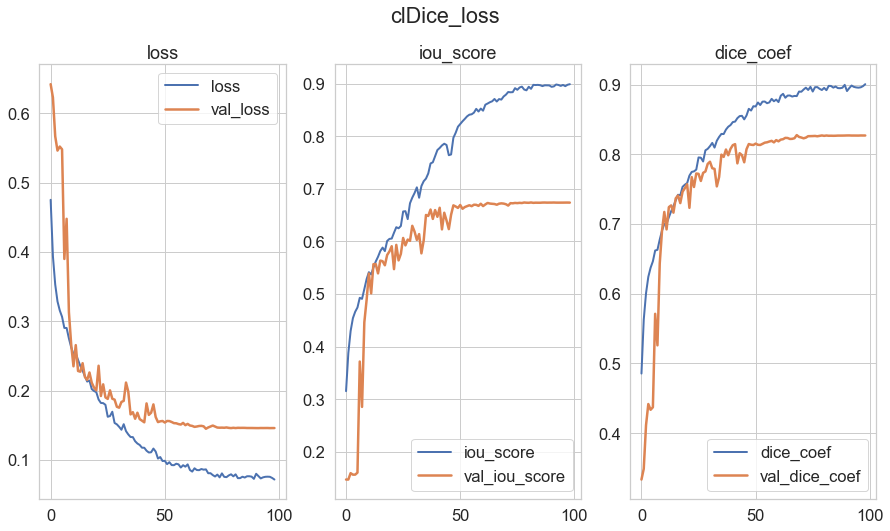


Epoch 00099: val_loss did not improve from 0.14499

Epoch 00099: ReduceLROnPlateau reducing learning rate to 2.1869998079182552e-08.
Epoch 00099: early stopping


In [13]:
for i in range(0, loss_list):
    model = get_model()
    optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    if i == 0:
        loss_name = "DiceBCE Loss"
        loss = DiceBCELoss
    elif i == 1:
        loss_name = "Focal Loss"
        loss = focal_loss
    elif i == 2:
        loss_name = "Tversky Loss"
        loss = tversky_loss
    elif i == 3:
        loss_name = "Weighted Cross Entropyloss"
        loss = weighted_cross_entropyloss
    elif i == 4:
        loss_name = "Combo_loss"
        loss = Combo_loss
    elif i == 5:
        loss_name = "FocalTverskyLoss"
        loss = FocalTverskyLoss
    elif i == 6:
        loss_name = "clDice_loss"
        loss = soft_cldice_loss  
        
    model.compile(optimizer=optimizer, loss = loss, metrics=[metrics, dice_coef])
    history = model.fit(X_train, y_train_cat,
                    batch_size=2,
                    verbose=1,
                    epochs=200,
                    validation_data=(X_val, y_val_cat),
#                     class_weight=class_weights
                    shuffle=True,
                    callbacks=[plotLoss,checkpoint,reduce_lr_on_plateau, early_stopping])
    
    model_path_name = model_save_path + loss_name + '_U_net_' + str(model_number)
    model.save(model_path_name + '.h5')

    with open(model_path_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Predict

In [15]:
def new_predict(model, num_samples, indices=None):
    import time
    import random
    
    tic = time.time()
    if indices is not None:
        samples_ind = indices
        
    predictions = model.predict(X_test, batch_size=4)
    
    toc = time.time()
    print('Time per image = {:.4f} sec'.format((toc-tic) / num_samples))
    return X_test2, y_test2, predictions

def images_overlay(x, y, threshold=1e-2, title=None, alpha=0.25, cmap='winter_r', ax=None, figsize=(5,5)):
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.imshow(x)

    mask = np.ma.masked_less(y, threshold)
    print("mask", mask.shape)

    ax.contourf(mask >  threshold, alpha=alpha, cmap=cmap)
    ax.contour(y, levels=[threshold], alpha=1.0, cmap=cmap)

    ax.axis('off')
    
    if title is not None:
        ax.set_title(title, fontsize=28)
        
def plot_prediction(x, y, y_pred_unet, sample):
    
    if sample >= len(y_pred_unet):
        raise ValueError('sample {} does not exist, max = {}'.format(sample, len(y_pred_unet)-1))
        
    fig, ax = plt.subplots(1,2,figsize=(30,25))
    images_overlay(x[sample], y_pred_unet[sample], ax=ax[0], threshold = 1e-1, title='prediction UNet')
    images_overlay(x[sample], y[sample], ax=ax[1], title='annotation')
#     plt.imshow(y_pred_unet[sample], cmap='gray')
    plt.show()
    
def test_num(data):
    import random
    n = []
    for i in range(len(data)):
        ran_num = random.randint(0, len(data)-1)
        while ran_num in n:
            ran_num = random.randint(0, len(data)-1)
        n.append(ran_num)
    return n

In [ ]:

model_name = ["Combo", "DiceCE", "Focal", "focal", "tversky", "weighted","clDice"]

# 테스트 세트의 인덱스 중복 없이 가져오기
n = test_num(X_test) # len(X_test) => 17

model_path = r"F:\Touchingcell\Data\model_save_folder/"
image_save_path = r"F:\Touchingcell\Data\image_save_folder/"

model_cat = glob.glob(os.path.join(model_path,'*_10.h5'))

# Load model
for model in model_cat:
    model_name_split = model.split("\\")
    model_name_split2 = model_name_split[-1].split("_")
    
    if model_name_split2[0] == model_name[0]:
        custom_objects = {"Combo_loss": Combo_loss, "iou_score": metrics, "dice_coef": metrics}
        name = model_name[0]
    elif model_name_split2[0] == model_name[1]:
        custom_objects = {"DiceBCELoss": DiceBCELoss, "iou_score": metrics, "dice_coef": metrics}
        name = model_name[1]
    elif model_name_split2[0] == model_name[2]:
        custom_objects = {"FocalTverskyLoss": FocalTverskyLoss, "iou_score": metrics, "dice_coef": metrics}
        name = model_name[2]
    elif model_name_split2[0] == model_name[3]:
        custom_objects = {"focal_loss": focal_loss, "iou_score": metrics, "dice_coef": metrics}
        name = model_name[3]
    elif model_name_split2[0] == model_name[4]:
        custom_objects = {"tversky_loss": tversky_loss, "iou_score": metrics, "dice_coef": metrics}
        name = model_name[4]
    elif model_name_split2[0] == model_name[5]:
        custom_objects = {"weighted_cross_entropyloss": weighted_cross_entropyloss, "iou_score": metrics, "dice_coef": metrics}
        name = model_name[5]
    elif model_name_split2[0] == model_name[6]:
        custom_objects = {"soft_cldice_loss": soft_cldice_loss, "iou_score": metrics, "dice_coef": metrics}
        name = model_name[6]
        
    model_unet = tf.keras.models.load_model(model, custom_objects)

    # Prediction
    y_pred=model_unet.predict(X_train, batch_size=4) # (17, 512, 512, 3)
    y_pred_argmax=np.argmax(y_pred, axis=3) # (17, 512, 512)

    num_samples = y_pred.shape[0] # 모든 test 이미지 출력
    # num_samples = 1 # 1개의 test 이미지 출력
    print(model_name_split[-1])
    x_data, y_data, y_pred_unet = new_predict(model_unet, num_samples)
    print("-"*50)
    print()
    n = 1

    # Predicted image output
    for j in range(n):
        test_img = X_test[j]
        ground_truth=y_test[j]

        test_img_input=np.expand_dims(test_img, 0)

        prediction = (model_unet.predict(test_img_input))
        print(np.unique(prediction))
        print(prediction.shape)

        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        # print(np.unique(predicted_img))
        # print(np.unique(ground_truth))

        # plt.figure(figsize=(36, 36))
        # plt.subplot(231)
        # plt.title('Test Image', fontdict = {'fontsize' : 40})
        # plt.imshow(x_data[j])
        # plt.grid(False)

        # plt.subplot(232)
        # plt.title('Test Annotation', fontdict = {'fontsize' : 40})
        # plt.imshow(ground_truth)
        # plt.grid(False)

        # plt.subplot(233)
        # plt.title('Prediction', fontdict = {'fontsize' : 40})
        # plt.imshow(predicted_img)
        # plt.grid(False)
        # # plt.imsave(image_save_path + "\\" + name + "_" + str(j) + ".png", predicted_img)
        # plt.show()

        print(predicted_img.shape)
        print(np.unique(predicted_img))